- This script tries to reproduce a few figures from Fuernkranz et al. (2012) paper to ensure that the coded `ChemoSimulation-v0` works as intended.

In [1]:
import gym
import chemo_simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
env = gym.make('ChemoSimulation-v0')

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Recreate `Fig. 6` of Fuernkranz et al. (2012) paper

In [51]:
# Dosages to provide to patient
dosage_levels = np.array([1. ,.7 , .1, .7, 1., .7])

In [52]:
# Create patient: initial Tumor size and wellness
starting_state = np.array([1.5]),np.array([0.5])

# Simulate the environment
env.reset(init_state = starting_state)

obs_list = []
obs_list.append(starting_state)

for dosage in dosage_levels:
    obs, reward, done, p_death = env.step(np.array([dosage]))
    obs_list.append(obs)
    if done:
        break

In [53]:
# Data for the plot
tumor_s = [t_size[0] for t_size, wellness in obs_list]
welness = [wellness[0] for t_size, wellness in obs_list]
dosage_levels = np.insert(dosage_levels, 0, -1)

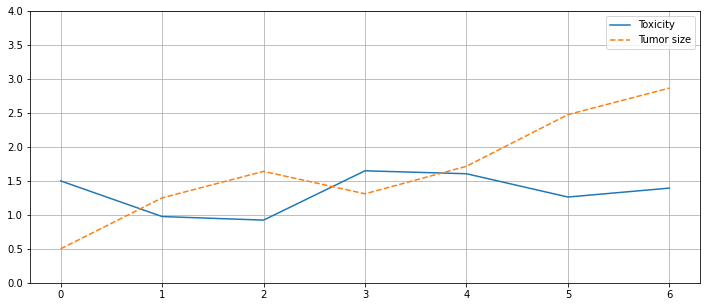

In [54]:
# Create the plot
fig, ax = plt.subplots(figsize = (12,5))

sns.lineplot(x = np.arange(0,len(dosage_levels))
             , y = tumor_s
             , ax = ax)
sns.lineplot(x = np.arange(0,len(dosage_levels))
            , y = welness
            , ax = ax)

ax.lines[1].set_linestyle("--")
ax.legend(['Toxicity', 'Tumor size'])
ax.set(ylim=(0, 4))
plt.grid()
plt.show()


<img src="graphics/FHCP_paper_fig_6.PNG">

### Recreate `Fig. 7` of Fuernkranz et al. (2012) paper

In [3]:
def generate_patients(patient_count = 200, seed=0):
    np.random.seed(seed)
    
    # setting initial tumor size to be larger than 0 -> otherwise treatment will not have any effect!
    return np.random.uniform(low=(0,0), high=(2,2), size = (patient_count,2,))

In [41]:
dosages =    {'low': np.array([0.1])
            , 'mid': np.array([0.4])
            , 'rand': None
            , 'high': np.array([0.7])
            , 'extreme': np.array([1.])}


selected_patients = generate_patients(seed=30)

patient_dic = {}

patient_count = 0
# Run test for 200 patients
for patient in selected_patients:
    
    obs_dic = {}
    
    for level, dosage in dosages.items():

        # Create patient: initial Tumor size and wellness
        starting_state = np.array([patient[0]]),np.array([patient[1]])
        
        obs_dic[level] = []
        obs_dic[level].append(starting_state)

        # Simulate the environment
        env.reset(init_state = starting_state)

        if level == 'rand':
            # Run treatment for 6 months
            for _ in range(7):
                obs, reward, done, p_death = env.step(np.array([np.random.choice(np.array([0.1,0.4,0.7,1.]))]))
                if done:
                    break
                obs_dic[level].append(obs)
        else:
            # Run treatment for 6 months
            for _ in range(7):
                obs, reward, done, p_death = env.step(dosage)
                if done:
                    break
                obs_dic[level].append(obs)
                    
    patient_dic[patient_count] = obs_dic
    patient_count += 1
        

In [42]:
# Select data for the plot from each patient
def get_stats(dic_vals):
    h_tox = np.array(dic_vals)[:,1].max()
    t_size = np.array(dic_vals)[-1,0][0]
    
    return h_tox, t_size

patient_data = {}

for patient, patient_obs in patient_dic.items():
    
    plot_data = {}

    for level, obs in obs_dic.items():

        plot_data[level] = get_stats(obs)
        
    patient_data[patient] = plot_data

# Aggregate data from every patient
df_li = []
for patient, plot_data in patient_data.items():
    tmp_df = pd.DataFrame(plot_data).T
    tmp_df.columns = ['Max. Toxicity', 'Tumor Size']
    tmp_df.loc[:,'Patient'] = patient
    df_li.append(tmp_df)


# Compute the averages
plot_df = pd.concat(df_li,axis=0)
plot_df.reset_index(inplace=True)

plot_df_summary = plot_df.groupby(['index'])[['Max. Toxicity','Tumor Size']].mean().reset_index()
plot_df_summary.sort_values('Tumor Size',inplace=True)

plot_df_summary.set_index('index',inplace=True)
plot_df_summary

,Max. Toxicity,Tumor Size
index,,
extreme,5.559356,0.195235
high,3.039356,1.581235
rand,2.302386,2.526016
mid,0.831422,3.040647
low,0.058428,5.279818


In [43]:
# Data for the connecting line (excluding random dosage)
line_y = plot_df_summary.loc[(plot_df_summary.index == 'extreme') | (plot_df_summary.index == 'high') | (plot_df_summary.index == 'mid') | (plot_df_summary.index == 'low'),'Max. Toxicity'].values
line_x = plot_df_summary.loc[(plot_df_summary.index == 'extreme') | (plot_df_summary.index == 'high') | (plot_df_summary.index == 'mid') | (plot_df_summary.index == 'low'), 'Tumor Size'].values

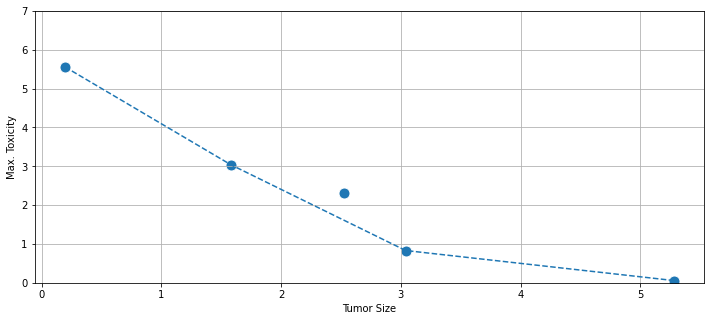

In [44]:
# Create the plot
fig2, ax2 = plt.subplots(figsize = (12,5))

sns.scatterplot(x='Tumor Size'
               , y= 'Max. Toxicity'
               , data = plot_df_summary
               , s=120
               , ax = ax2)

sns.lineplot(x = line_x
            , y = line_y
            , ax = ax2)


ax2.lines[0].set_linestyle("--")
ax2.set(ylim=(0, 7))
plt.grid()
plt.show()

In [8]:
def run_experiment(seed):
    """
    Function to run the experiment and produce summary results.
    """
    
    dosages =    {'low': np.array([0.1])
                , 'mid': np.array([0.4])
                , 'rand': None
                , 'high': np.array([0.7])
                , 'extreme': np.array([1.])}


    selected_patients = generate_patients(seed=seed)

    patient_dic = {}

    patient_count = 0
    # Run test for 200 patients
    for patient in selected_patients:

        obs_dic = {}

        for level, dosage in dosages.items():

            # Create patient: initial Tumor size and wellness
            starting_state = np.array([patient[0]]),np.array([patient[1]])

            obs_dic[level] = []
            obs_dic[level].append(starting_state)

            # Simulate the environment
            env.reset(init_state = starting_state)

            if level == 'rand':
                # Run treatment for 6 months
                for _ in range(7):
                    rand_action = np.array([np.random.choice(np.array([0.1,0.4,0.7,1.]))])
                    obs, reward, done, p_death = env.step(rand_action)
                    if done:
                        break
                    obs_dic[level].append(obs)
            else:
                # Run treatment for 6 months
                for _ in range(7):
                    obs, reward, done, p_death = env.step(dosage)
                    if done:
                        break
                    obs_dic[level].append(obs)

        patient_dic[patient_count] = obs_dic
        patient_count += 1
        
        
    # Select data for the plot from each patient
    def get_stats(dic_vals):
        h_tox = np.array(dic_vals)[:,1].max()
        t_size = np.array(dic_vals)[-1,0][0]

        return h_tox, t_size

    patient_data = {}

    for patient, patient_obs in patient_dic.items():

        plot_data = {}

        for level, obs in obs_dic.items():

            plot_data[level] = get_stats(obs)

        patient_data[patient] = plot_data

    # Aggregate data from every patient
    df_li = []
    for patient, plot_data in patient_data.items():
        tmp_df = pd.DataFrame(plot_data).T
        tmp_df.columns = ['Max. Toxicity', 'Tumor Size']
        tmp_df.loc[:,'Patient'] = patient
        df_li.append(tmp_df)


    # Compute the averages
    plot_df = pd.concat(df_li,axis=0)
    plot_df.reset_index(inplace=True)

    plot_df_summary = plot_df.groupby(['index'])[['Max. Toxicity','Tumor Size']].mean().reset_index()
    plot_df_summary.sort_values('Tumor Size',inplace=True)

    plot_df_summary.set_index('index',inplace=True)

    print(plot_df_summary)
    
    # Data for the connecting line (excluding random dosage)
    line_y = plot_df_summary.loc[(plot_df_summary.index == 'extreme') | (plot_df_summary.index == 'high') | (plot_df_summary.index == 'mid') | (plot_df_summary.index == 'low'),'Max. Toxicity'].values
    line_x = plot_df_summary.loc[(plot_df_summary.index == 'extreme') | (plot_df_summary.index == 'high') | (plot_df_summary.index == 'mid') | (plot_df_summary.index == 'low'), 'Tumor Size'].values
    
    # Create the plot
    fig2, ax2 = plt.subplots(figsize = (12,5))

    sns.scatterplot(x='Tumor Size'
                   , y= 'Max. Toxicity'
                   , data = plot_df_summary
                   , s=120
                   , ax = ax2)

    sns.lineplot(x = line_x
                , y = line_y
                , ax = ax2)


    ax2.lines[0].set_linestyle("--")
    ax2.set(ylim=(0, 7))
    plt.grid()
    plt.show()

    

         Max. Toxicity  Tumor Size
index                             
extreme       5.559356    0.195235
high          3.039356    1.581235
rand          2.302386    2.526016
mid           0.831422    3.040647
low           0.058428    5.279818


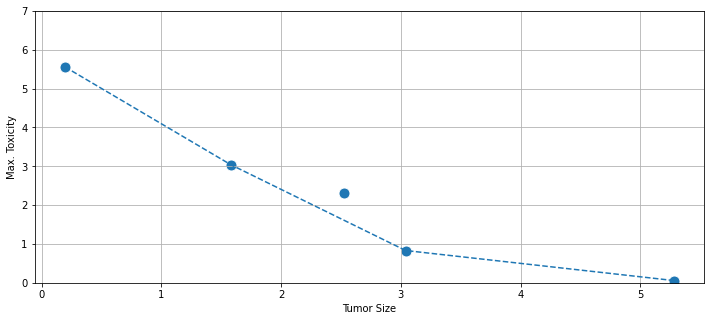

In [39]:
run_experiment(seed=30)

<img src="graphics/FHCP_paper_fig_7.PNG">

### An instance where the performance of the `random policy` falls out-side of the convex hull

This also proves that the measured policy performance is sensitive to the initial patient selection.

         Max. Toxicity  Tumor Size
index                             
extreme       5.283491    0.000000
rand          3.521043    0.000000
high          2.763491    0.691861
mid           0.655116    2.207672
low           0.506358    4.716151


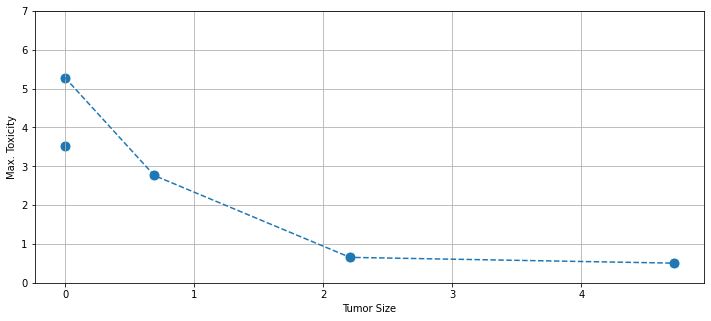

In [50]:
run_experiment(seed=10) # Changing the seed value forces to use a different set of patients 